# SARIMA model:
## training mode: separate for each stock and for each task

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Get Data and Preprocess

In [ ]:
Xy_train_org = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train.csv')
Xy_val_org = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val.csv')
LOOKBACK = 60

In [ ]:
Xy_train = Xy_train_org.groupby(['security', 'date_y']).mean().reset_index()
Xy_val = Xy_val_org.groupby(['security', 'date_y']).mean().reset_index()

<ipython-input-4-7e1e6df824b2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Xy_train = Xy_train_org.groupby(['security', 'date_y']).mean().reset_index()
<ipython-input-4-7e1e6df824b2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Xy_val = Xy_val_org.groupby(['security', 'date_y']).mean().reset_index()


In [ ]:
Xy_train.columns

Index(['security', 'date_y', 'RELEVANT_SENTIMENT_SCORE_mean',
       'RELEVANT_SENTIMENT_SCORE_min', 'RELEVANT_SENTIMENT_SCORE_max', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume', 'daily_return',
       'price_diff', 'roc_vol', 'ma5_close', 'close_vs_ema5', 'vol_vs_sma5',
       'ma10_close', 'close_vs_ema10', 'vol_vs_sma10', 'ma15_close',
       'close_vs_ema15', 'vol_vs_sma15', 'EMA05_Open', 'EMA05_High',
       'EMA05_Low', 'EMA05_Close', 'EMA05_Adj Close', 'high10atr', 'RSI',
       'MFI', 'STOCH', 'MACD', 'MACD_signal', 'lag1_MONTHLY_RETURN_diff',
       'lag1_MONTHLY_RETURN_log', 'lag1_ma5_MONTHLY_RETURN',
       'lag1_ma10_MONTHLY_RETURN', 'lag1_ma15_MONTHLY_RETURN',
       'lag1_RSI_MONTHLY_RETURN', 'lag1_MACD_MONTHLY_RETURN',
       'lag1_MACD_signal_MONTHLY_RETURN', 'lag1_MONTHLY_RETURN_F1_diff',
       'lag1_MONTHLY_RETURN_F1_log', 'lag1_ma5_MONTHLY_RETURN_F1',
       'lag1_ma10_MONTHLY_RETURN_F1', 'lag1_ma15_MONTHLY_RETURN_F1',
       'lag1_RSI_MONTHLY_RETURN

In [ ]:
Xy_train

,security,date_y,RELEVANT_SENTIMENT_SCORE_mean,RELEVANT_SENTIMENT_SCORE_min,RELEVANT_SENTIMENT_SCORE_max,Open,High,Low,Close,Adj Close,...,lag1_MONTHLY_RETURN_F1_diff,lag1_MONTHLY_RETURN_F1_log,lag1_ma5_MONTHLY_RETURN_F1,lag1_ma10_MONTHLY_RETURN_F1,lag1_ma15_MONTHLY_RETURN_F1,lag1_RSI_MONTHLY_RETURN_F1,lag1_MACD_MONTHLY_RETURN_F1,lag1_MACD_signal_MONTHLY_RETURN_F1,MONTHLY_RETURN,MONTHLY_RETURN_F1
0,AMZN US Equity,2020-01-31,22.232416,-20.434483,54.034483,103.520012,107.661758,100.757507,103.368027,103.368027,...,0.006447,-2.825787,0.018603,0.017739,0.018390,50.521310,0.003081,0.001245,0.087064,-0.062214
1,AMZN US Equity,2020-02-28,21.934979,-15.851852,50.740741,105.376357,107.973330,103.552151,105.155177,105.155177,...,0.006447,-2.825787,0.018603,0.017739,0.018390,50.521310,0.003081,0.001245,-0.062214,0.035021
2,AMZN US Equity,2020-03-31,11.577539,-27.846154,49.900000,103.520012,107.661758,100.757507,103.368027,103.368027,...,0.097234,-3.351820,0.018603,0.017739,0.018390,50.521310,0.003081,0.001245,0.035021,0.268900
3,AMZN US Equity,2020-04-30,6.086947,-47.496296,57.148148,111.710431,114.720679,109.416225,111.973529,111.973529,...,0.233880,-1.313415,0.018603,0.017739,0.018390,50.521310,0.003081,0.001245,0.268900,-0.012785
4,AMZN US Equity,2020-05-29,18.095551,-32.214286,57.750000,119.596732,120.889268,118.155089,119.527501,119.527501,...,-0.281685,-1.313415,0.018603,0.017739,0.018390,50.521310,0.003081,0.001245,-0.012785,0.129567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,YUM US Equity,2021-11-30,9.294444,6.995238,14.328571,125.899047,126.843809,125.032856,125.825714,121.355966,...,-0.038311,-3.839575,0.015526,0.021006,0.018626,50.122791,0.001425,0.000253,-0.016808,0.130414
671,YUM US Equity,2021-12-31,19.650000,12.320000,24.160000,132.604399,134.096400,131.989199,133.017599,128.704688,...,0.147222,-2.037045,0.013164,0.032037,0.030485,54.765666,0.001425,0.000253,0.130414,-0.098589
672,YUM US Equity,2022-01-31,0.000000,0.000000,0.000000,128.853499,129.858001,127.098501,128.261000,124.102319,...,-0.229002,-2.037045,-0.006006,0.017687,0.022430,47.868066,0.001425,0.000253,-0.098589,-0.020692
673,YUM US Equity,2022-02-28,22.991597,13.380952,27.619048,123.810475,125.635239,122.726190,124.062382,120.278160,...,0.077897,-2.037045,0.003166,0.005135,0.012143,49.773492,0.001425,0.000253,-0.020692,-0.033040


In [ ]:
FINAL_FEATURES = []
for col in list(Xy_train.columns):
  if col != 'security' and col != 'date_x' and col !=  'month' and col != 'date_y' and col != 'MONTHLY_RETURN' and col !=  'MONTHLY_RETURN_F1':
    FINAL_FEATURES.append(col)

In [ ]:
def get_data_ML(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  FINAL_FEATURES: input X features, does not include y label, which is dependent on task
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  Note: for traditional models, there is no sliding window. X_train and X_val are 2D (sample, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    target = 'MONTHLY_RETURN'
    f.append('MONTHLY_RETURN') # f is all the columns to extrac, including the y label
  else:
    f = features.copy()
    target = 'MONTHLY_RETURN_F1'
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  stocks25 = {} # a dict of dicts : {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  securities = list(Xy_train.security.unique())
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    train_dates = Xy_train[Xy_train['security']==security]['date_y']
    train_dates = pd.to_datetime(train_dates)
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)
    train_stock_scaled = pd.DataFrame(train_stock_scaled, columns = f, index = train_dates)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    val_dates = Xy_val[Xy_val['security']==security]['date_y']
    val_dates = pd.to_datetime(val_dates)
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)
    val_stock_scaled = pd.DataFrame(val_stock_scaled, columns = f, index = val_dates)

    y_train_stock = train_stock_scaled[target]
    y_val_stock =  val_stock_scaled[target]
    X_train_stock = train_stock_scaled[features]
    X_val_stock = val_stock_scaled[features]

    print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

    stock_og = {}
    stock_og['X_train'] = X_train_stock
    stock_og['y_train'] = y_train_stock
    stock_og['X_val'] = X_val_stock
    stock_og['y_val'] = y_val_stock
    stocks25[security] = stock_og

  return stocks25


def get_ONE_data_ML(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  returns one dataset for all stocks, the security infomation is lost.
  stocks = {'X_train':data, 'X_val':data .. }
  """
  # organize features
  if task == 'current':
    f = features.copy()
    target = 'MONTHLY_RETURN'
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    target = 'MONTHLY_RETURN_F1'
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")

  # train
  train_stock = Xy_train[f].values # take sure columns are int he right order
  scalar_stock_train = StandardScaler()
  train_stock_scaled = scalar_stock_train.fit_transform(train_stock)
  train_stock_scaled = pd.DataFrame(train_stock_scaled, columns = f)

  # validation
  val_stock = Xy_val[f].values
  scalar_stock_val = StandardScaler()
  val_stock_scaled = scalar_stock_val.fit_transform(val_stock)
  val_stock_scaled = pd.DataFrame(val_stock_scaled, columns = f)

  y_train_stock = train_stock_scaled[target]
  y_val_stock =  val_stock_scaled[target]
  X_train_stock = train_stock_scaled[features]
  X_val_stock = val_stock_scaled[features]

  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train_stock
  stocks['y_train'] = y_train_stock
  stocks['X_val'] = X_val_stock
  stocks['y_val'] = y_val_stock

  return stocks


In [ ]:
stock25_cur = get_data_ML(Xy_train, Xy_val, LOOKBACK, 'current',FINAL_FEATURES)
stock25_next = get_data_ML(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
AMZN US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
APTV US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
AZO US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
BKNG US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
CCL US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
CMG US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
DG US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(16, 48), y_val shape:(16,)
EBAY US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
F US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val shape :(17, 48), y_val shape:(17,)
GM US Equity: X_train shape :(27, 48), y_train shape:(27,); X_val sh

In [ ]:
stock_ONE_cur = get_ONE_data_ML(Xy_train, Xy_val, LOOKBACK,  'current', FINAL_FEATURES)
stock_ONE_next = get_ONE_data_ML(Xy_train, Xy_val, LOOKBACK, 'next', FINAL_FEATURES)

TASK:current
TASK:next


In [ ]:
stock25_cur['YUM US Equity']['y_train']

date_y
2020-01-31    0.411178
2020-02-28   -1.741661
2020-03-31   -2.534730
2020-04-30    2.615608
2020-05-29    0.287434
2020-06-30   -0.439240
2020-07-31    0.386131
2020-08-31    0.439192
2020-09-30   -0.606712
2020-10-30    0.120959
2020-11-30    1.283672
2020-12-31    0.161177
2021-01-29   -0.791022
2021-02-26    0.098682
2021-03-31    0.357725
2021-04-30    0.983157
2021-05-31   -0.071850
2021-06-30   -0.541017
2021-07-30    1.373574
2021-08-31   -0.139758
2021-09-30   -0.805892
2021-10-29    0.113321
2021-11-30   -0.286620
2021-12-31    1.250283
2022-01-31   -1.140358
2022-02-28   -0.327165
2022-03-31   -0.456068
Name: MONTHLY_RETURN, dtype: float64

# Modeling

In [ ]:
X_train = stock_ONE_cur['X_train']
y_train = stock_ONE_cur['y_train']
X_val = stock_ONE_cur['X_val']
y_val = stock_ONE_cur['y_val']

In [ ]:
X_train.columns

Index(['RELEVANT_SENTIMENT_SCORE_mean', 'RELEVANT_SENTIMENT_SCORE_min',
       'RELEVANT_SENTIMENT_SCORE_max', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'daily_return', 'price_diff', 'roc_vol',
       'ma5_close', 'close_vs_ema5', 'vol_vs_sma5', 'ma10_close',
       'close_vs_ema10', 'vol_vs_sma10', 'ma15_close', 'close_vs_ema15',
       'vol_vs_sma15', 'EMA05_Open', 'EMA05_High', 'EMA05_Low', 'EMA05_Close',
       'EMA05_Adj Close', 'high10atr', 'RSI', 'MFI', 'STOCH', 'MACD',
       'MACD_signal', 'lag1_MONTHLY_RETURN_diff', 'lag1_MONTHLY_RETURN_log',
       'lag1_ma5_MONTHLY_RETURN', 'lag1_ma10_MONTHLY_RETURN',
       'lag1_ma15_MONTHLY_RETURN', 'lag1_RSI_MONTHLY_RETURN',
       'lag1_MACD_MONTHLY_RETURN', 'lag1_MACD_signal_MONTHLY_RETURN',
       'lag1_MONTHLY_RETURN_F1_diff', 'lag1_MONTHLY_RETURN_F1_log',
       'lag1_ma5_MONTHLY_RETURN_F1', 'lag1_ma10_MONTHLY_RETURN_F1',
       'lag1_ma15_MONTHLY_RETURN_F1', 'lag1_RSI_MONTHLY_RETURN_F1',
       'lag1_MACD_MONTH

## Test if all the columns are stationary (wrapped in functions):
- and they are!
- although SARIMA can deal better with nonstationary data, I still wanna check it's stationary (so that if it's not I can do smoothing or differencing)

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def test_stationarity(y):
    # Calculate rolling statistics
    rol_mean = y.rolling(window=12).mean()
    rol_std = y.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(14,4))
    plt.plot(y, color='b', label='Original')
    plt.plot(rol_mean, color='r', label='Rolling Mean')
    plt.plot(rol_std, color='g', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y_val, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    z_obs = dfoutput['Test Statistic']
    z_5 = dftest[4]['5%']
    if z_obs < z_5:
      print('Result: Stationary')
    else:
      print('Result: Non-Stationary')
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value


    return z_obs < z_5

# Example usage:
# Assuming 'ts' is a pandas Series containing the time series data
# test_stationarity(ts)


In [ ]:

def sarimax_forecast(SARIMAX_model, X_val, y_val, security = None, task = None, exo_features = None, exo = False):
    """
    @params:
      X_val: validation set features
      y_val: real y labels in the validation set
      TASK: 'current' or 'next'
      features: features in X_val to use to assist prediction, do not include labels
      exo: whether we wanna use additional features

    """
    if task == 'current':
      target = 'MONTHLY_RETURN'
    else:
      target = 'MONTHLY_RETURN_F1'

    # Forecast
    fcperiods = len(y_val)

    # if we use exogenous features
    if exo:
      fitted, confint = SARIMAX_model.predict(n_periods=fcperiods,
                                              return_conf_int=True,
                                              exogenous=X_val[exo_features])
    # if only using y
    else:
      fitted, confint = SARIMAX_model.predict(n_periods=fcperiods,
                                              return_conf_int=True)

    r_squared_adjusted = r2_score(y_val, fitted) #
    mse = mean_squared_error(y_val, fitted)
    rmse = np.sqrt(mse)

    # if we

    index_of_fc = y_val.index
    #print(fitted)
    # make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc) # y_pred
    pred_org = {'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':fitted, 'y': y_val}
    #print(fitted_series)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(y_val, color='blue', label = 'y_TRUE')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                   color='k', alpha=.15)
    plt.plot(fitted_series, color='darkgreen', label = 'y_pred')
    plt.legend()

    plt.title(f"SARIMAX - Forecast of {security}")
    plt.show()
    return pred_org




In [ ]:
from types import NoneType
def iter_checkstationary(df):
  """
  df: stock25_cur/next
  check if the training y values are stationary
  """
  sub_dfs = []
  each_stock = {}
  for security, security_ds in df.items():
    security_X_train = security_ds['X_train']
    security_y_train = security_ds['y_train']
    security_X_val = security_ds['X_val']
    security_y_val = security_ds['y_val']
    stationary = test_stationarity(security_y_train)
    if not stationary:
      print(f'{security} y_train is not stationary!')
      break

# given a general df containing all securities, split into datasets for each stock and apply the function "f" to each of them
# return:
# new_df: data for all stocks
# sub_dfs: data for each stock
def iter_allstock(df, task = None, exo = False, exo_features = None):

  all_preds = {}
  for security, security_ds in df.items():
    security_X_train = security_ds['X_train']
    security_y_train = security_ds['y_train']
    security_X_val = security_ds['X_val']
    security_y_val = security_ds['y_val']
    if not exo:
      security_SARIMA_model = pm.auto_arima(security_y_train,
                          start_p=1, start_q=1,
                          test='adf',
                          max_p=2, max_q=2,
                          m=12, #12 is the frequncy of the cycle, montly
                          start_P=0,
                          seasonal=True, #set to seasonal
                          d=None,
                          D=1, #order of the seasonal differencing
                          trace=False,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    else:
      security_SARIMA_model = pm.auto_arima(security_y_train, exogenous=security_X_train[exo_features],
                          start_p=1, start_q=1,
                          test='adf',
                          max_p=2, max_q=2,
                          m=12, #12 is the frequncy of the cycle, montly
                          start_P=0,
                          seasonal=True, #set to seasonal
                          d=None,
                          D=1, #order of the seasonal differencing
                          trace=False,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    security_SARIMA_model.plot_diagnostics(figsize=(15,12))
    plt.show()
    security_pred = sarimax_forecast(security_SARIMA_model,  security_X_val, security_y_val, security = security, task = task, exo = exo, exo_features = exo_features)
    all_preds[security] = security_pred

  return all_preds


In [ ]:
def analyze(pred25_cur, mode, exo = None, task = None):
    """
    generate prediction vs y_true plot
    save evaluation metrics to path.
    """
    # Iterate over each stock in the dictionary
    for stock_name, predictions in pred25_cur.items():
        y_preds = predictions['y_preds']
        y = predictions['y']

        # Create a figure and axis
        fig, ax = plt.subplots()
        print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


        # Plot the real returns (y) in blue
        ax.plot(y, label='Real Returns', color='blue')

        # Plot the predicted returns (y_preds) in red
        ax.plot(y_preds, label='Predicted Returns', color='red')

        # Set axis labels and a legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Returns')
        ax.set_title(f'{stock_name} - Real vs. Predicted Returns')
        ax.legend()

        # Display or save the plot as needed
        plt.show()  # Use
        #plot_path = f'/content/gdrive/MyDrive/lazard/models/task_{task}/outputs/{mode}SARIMA_{task}.png'
        #plt.savefig(plot_path) # to save the plot to a file

    pred25_cur = pd.DataFrame(pred25_cur)
    analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_{task}/outputs/{mode}SARIMA_{task}_exo{exo}.csv'
    pred25_cur.to_csv(analysis_path)
    return pred25_cur




# MONTHLY RETURN TASK

In [ ]:
preds25_cur = iter_allstock(stock25_cur, task = 'current')
preds25_cur_df = analyze(preds25_cur, 'sep', task = 'current')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
preds25_cur_df

,AMZN US Equity,APTV US Equity,AZO US Equity,BKNG US Equity,CCL US Equity,CMG US Equity,DG US Equity,EBAY US Equity,F US Equity,GM US Equity,...,MCD US Equity,NKE US Equity,ORLY US Equity,RCL US Equity,ROST US Equity,SBUX US Equity,TGT US Equity,TJX US Equity,VFC US Equity,YUM US Equity
r_squared_adjusted,-1.087271,-0.379479,-133.450334,-1.278258,-9.168713,-1.015793,-0.299881,-6.570744,-47.159646,-29.401301,...,-174.16397,-0.457101,-0.299122,-195.652748,-1.310031,-1.852654,-1.227982,-1.16731,-1.542849,-0.278131
rmse,1.444739,1.174512,11.595272,1.50939,3.188842,1.419786,1.140123,2.751499,6.939715,5.513737,...,13.234953,1.207104,1.13979,14.023293,1.519879,1.68898,1.492643,1.472179,1.594631,1.130545
mse,2.087271,1.379479,134.450334,2.278258,10.168713,2.015793,1.299881,7.570744,48.159646,30.401301,...,175.16397,1.457101,1.299122,196.652748,2.310031,2.852654,2.227982,2.16731,2.542849,1.278131
y_preds,2022-04-29 1.924008 2022-05-31 -0.438256 ...,2022-04-29 0.181811 2022-05-31 0.195905 ...,2022-04-29 -2.151191 2022-05-31 -4.22355...,2022-04-29 2.228485 2022-05-31 -2.294089 ...,2022-04-29 0.300160 2022-05-31 -1.366479 ...,2022-04-29 0.196754 2022-05-31 -1.030804 ...,2022-05-31 -1.154718 2022-06-30 0.755177 ...,2022-04-29 -2.050495 2022-05-31 1.042788 ...,2022-04-29 -3.720171 2022-05-31 -0.64730...,2022-04-29 -2.964147 2022-05-31 -1.494180 ...,...,2022-04-29 -2.065419 2022-05-31 -3.86271...,2022-04-29 -0.197873 2022-05-31 0.193891 ...,2022-04-29 0.791982 2022-05-31 -0.597962 ...,2022-04-29 5.918972 2022-05-31 5.49222...,2022-04-29 0.354565 2022-05-31 -1.039677 ...,2022-04-29 -0.288974 2022-05-31 -0.947205 ...,2022-04-29 -0.338860 2022-05-31 0.198048 ...,2022-04-29 0.898510 2022-05-31 -1.319403 ...,2022-04-29 0.096914 2022-05-31 -1.566757 ...,2022-04-29 0.983157 2022-05-31 -0.071850 ...
y,date_y 2022-04-29 -0.703168 2022-05-31 -3....,date_y 2022-04-29 -0.838098 2022-05-31 -0....,date_y 2022-04-29 -0.977175 2022-05-31 0....,date_y 2022-04-29 -0.796934 2022-05-31 -0....,date_y 2022-04-29 -0.634787 2022-05-31 -0....,date_y 2022-04-29 -0.903695 2022-05-31 -0....,date_y 2022-05-31 -0.568261 2022-06-30 1....,date_y 2022-04-29 -0.806219 2022-05-31 -0....,date_y 2022-04-29 -0.973885 2022-05-31 -0....,date_y 2022-04-29 -0.993939 2022-05-31 0....,...,date_y 2022-04-29 -0.027754 2022-05-31 0....,date_y 2022-04-29 -0.584080 2022-05-31 -0....,date_y 2022-04-29 -2.013339 2022-05-31 0....,date_y 2022-04-29 -0.508086 2022-05-31 -1....,date_y 2022-04-29 0.796735 2022-05-31 -1....,date_y 2022-04-29 -2.154039 2022-05-31 0....,date_y 2022-04-29 0.894894 2022-05-31 -2....,date_y 2022-04-29 -0.240155 2022-05-31 0....,date_y 2022-04-29 -0.270970 2022-05-31 0....,date_y 2022-04-29 -0.288336 2022-05-31 0....


In [ ]:
check_features = ['RELEVANT_SENTIMENT_SCORE_mean', 'RELEVANT_SENTIMENT_SCORE_min',
       'RELEVANT_SENTIMENT_SCORE_max',
       'ma5_close', 'close_vs_ema5', 'vol_vs_sma5', 'ma10_close',
       'close_vs_ema10', 'vol_vs_sma10', 'ma15_close', 'close_vs_ema15',
       'vol_vs_sma15', 'EMA05_Open', 'EMA05_High', 'EMA05_Low', 'EMA05_Close',
       'EMA05_Adj Close', 'high10atr', 'RSI', 'MFI', 'STOCH', 'MACD',
       'MACD_signal', 'lag1_MONTHLY_RETURN_diff', 'lag1_MONTHLY_RETURN_log',
       'lag1_ma5_MONTHLY_RETURN', 'lag1_ma10_MONTHLY_RETURN',
       'lag1_ma15_MONTHLY_RETURN', 'lag1_RSI_MONTHLY_RETURN',
       'lag1_MACD_MONTHLY_RETURN', 'lag1_MACD_signal_MONTHLY_RETURN',
       'lag1_MONTHLY_RETURN_F1_diff', 'lag1_MONTHLY_RETURN_F1_log',
       'lag1_ma5_MONTHLY_RETURN_F1', 'lag1_ma10_MONTHLY_RETURN_F1',
       'lag1_ma15_MONTHLY_RETURN_F1', 'lag1_RSI_MONTHLY_RETURN_F1',
       'lag1_MACD_MONTHLY_RETURN_F1', 'lag1_MACD_signal_MONTHLY_RETURN_F1']

In [ ]:
fea = ['RELEVANT_SENTIMENT_SCORE_mean']

# MONTHLY_RETURN_F1 TASK

In [ ]:
#preds25_cur = iter_allstock(stock25_cur, task = 'current',  exo = True, exo_features = fea)
#preds25_cur_df = analyze(preds25_cur, 'sep', task = 'current',  exo = True,  exo_features = fea)
preds25_next = iter_allstock(stock25_next, task = 'next')
preds25_next_df = analyze(preds25_next, 'sep', task = 'next')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
preds25_next_df

,AMZN US Equity,APTV US Equity,AZO US Equity,BKNG US Equity,CCL US Equity,CMG US Equity,DG US Equity,EBAY US Equity,F US Equity,GM US Equity,...,MCD US Equity,NKE US Equity,ORLY US Equity,RCL US Equity,ROST US Equity,SBUX US Equity,TGT US Equity,TJX US Equity,VFC US Equity,YUM US Equity
r_squared_adjusted,-3294.153699,-1.433615,-32.875162,-134.650525,-1213.958144,-3.756644,-0.192291,-47.97248,-11.996672,-0.45904,...,-13.156278,-0.628843,-1.145232,-0.343094,-0.323876,-5.461747,-1.288098,-0.054667,-3.471091,-0.292646
rmse,57.403429,1.560005,5.820237,11.646911,34.85625,2.180973,1.091921,6.998034,3.60509,1.207907,...,3.762483,1.276261,1.464661,1.158919,1.150598,2.541997,1.512646,1.02697,2.114495,1.136946
mse,3295.153699,2.433615,33.875162,135.650525,1214.958144,4.756644,1.192291,48.97248,12.996672,1.45904,...,14.156278,1.628843,2.145232,1.343094,1.323876,6.461747,2.288098,1.054667,4.471091,1.292646
y_preds,2022-04-29 -9.138774 2022-05-31 -12.128...,2022-04-29 -0.466304 2022-05-31 -0.462277 ...,2022-04-29 -2.764937 2022-05-31 -1.95898...,2022-04-29 -5.190360 2022-05-31 -2.65781...,2022-04-29 3.117336 2022-05-31 3.92352...,2022-04-29 -2.172959 2022-05-31 -0.230258 ...,2022-05-31 0.762650 2022-06-30 0.899329 ...,2022-04-29 1.613583 2022-05-31 2.37180...,2022-04-29 1.323137 2022-05-31 0.253262 ...,2022-04-29 0.192848 2022-05-31 -0.120646 ...,...,2022-04-29 -1.901750 2022-05-31 -1.780415 ...,2022-04-29 0.202924 2022-05-31 1.493822 ...,2022-04-29 -1.238310 2022-05-31 -0.233344 ...,2022-04-29 0.273413 2022-05-31 -0.442044 ...,2022-04-29 -1.109856 2022-05-31 -0.314082 ...,2022-04-29 -1.596216 2022-05-31 -1.742879 ...,2022-04-29 -0.464870 2022-05-31 -0.320183 ...,2022-04-29 -0.652012 2022-05-31 -0.079182 ...,2022-04-29 -3.167165 2022-05-31 -1.523318 ...,2022-04-29 -0.047656 2022-05-31 -0.517913 ...
y,date_y 2022-04-29 -3.552053 2022-05-31 -0....,date_y 2022-04-29 -0.039882 2022-05-31 -1....,date_y 2022-04-29 0.628578 2022-05-31 0....,date_y 2022-04-29 -0.098807 2022-05-31 -2....,date_y 2022-04-29 -0.852656 2022-05-31 -1....,date_y 2022-04-29 -0.522749 2022-05-31 -0....,date_y 2022-05-31 1.735380 2022-06-30 0....,date_y 2022-04-29 -0.568148 2022-05-31 -1....,date_y 2022-04-29 -0.244927 2022-05-31 -1....,date_y 2022-04-29 0.171913 2022-05-31 -1....,...,date_y 2022-04-29 0.116014 2022-05-31 -0....,date_y 2022-04-29 -0.348055 2022-05-31 -1....,date_y 2022-04-29 0.412452 2022-05-31 -0....,date_y 2022-04-29 -1.398326 2022-05-31 -2....,date_y 2022-04-29 -1.586550 2022-05-31 -1....,date_y 2022-04-29 0.487445 2022-05-31 -0....,date_y 2022-04-29 -2.295792 2022-05-31 -0....,date_y 2022-04-29 0.193324 2022-05-31 -2....,date_y 2022-04-29 0.189496 2022-05-31 -0....,date_y 2022-04-29 0.565858 2022-05-31 -1....


y vs y_pred: (17,) vs (17,)


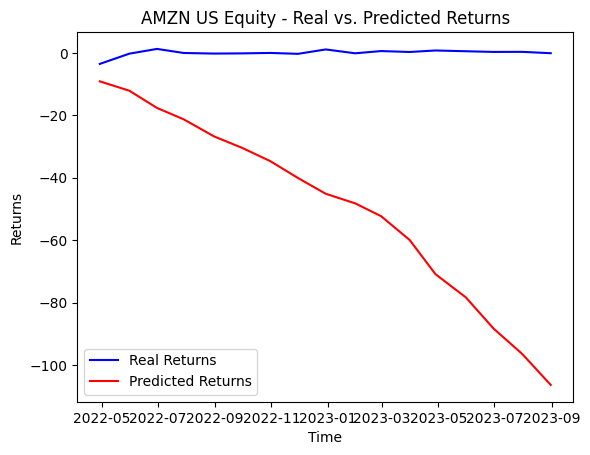

y vs y_pred: (17,) vs (17,)


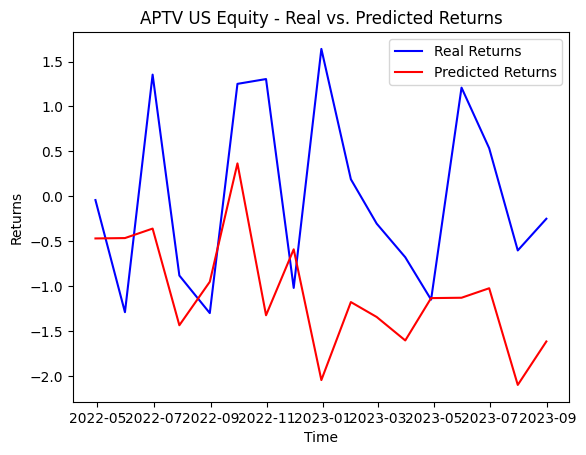

y vs y_pred: (17,) vs (17,)


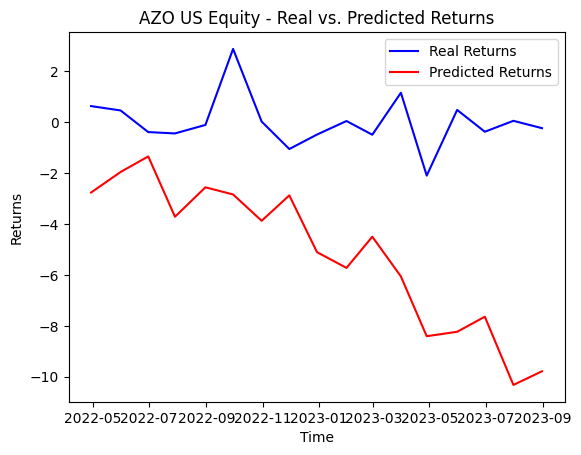

y vs y_pred: (17,) vs (17,)


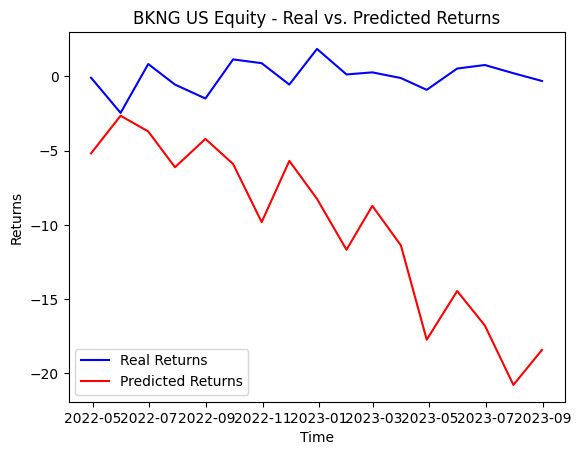

y vs y_pred: (17,) vs (17,)


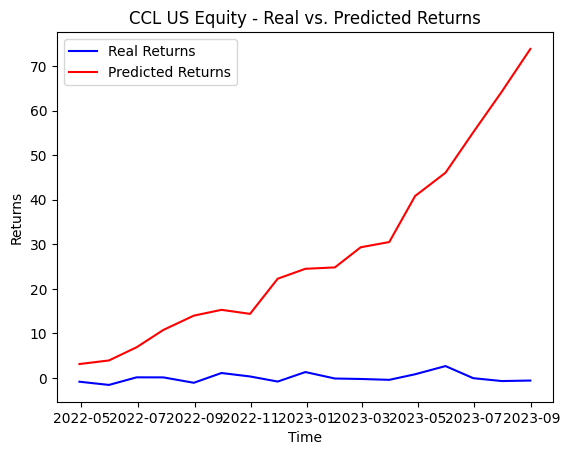

y vs y_pred: (17,) vs (17,)


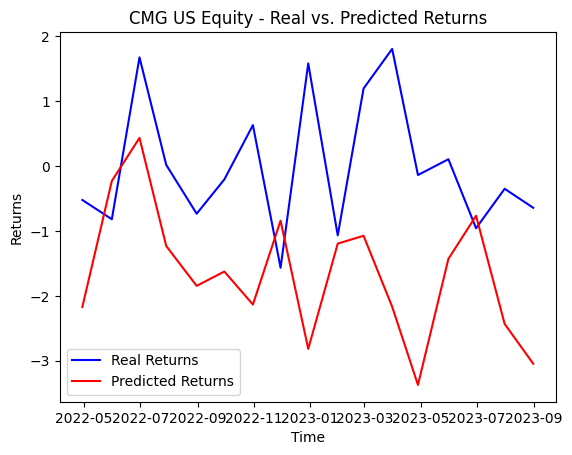

y vs y_pred: (16,) vs (16,)


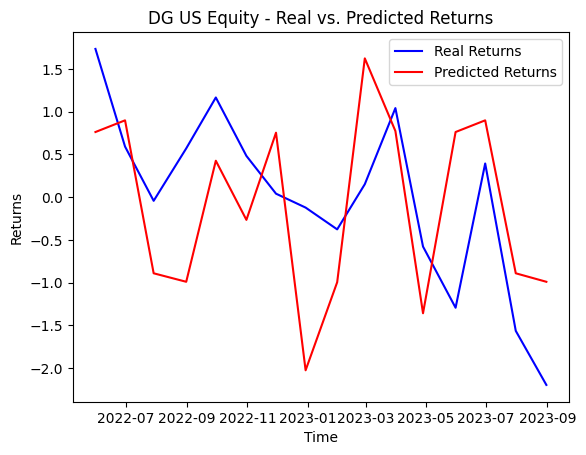

y vs y_pred: (17,) vs (17,)


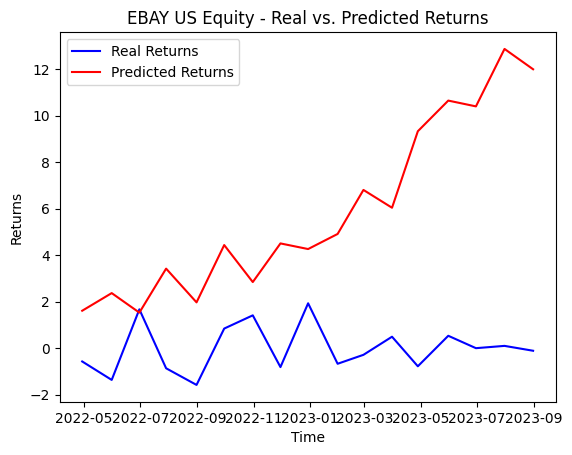

y vs y_pred: (17,) vs (17,)


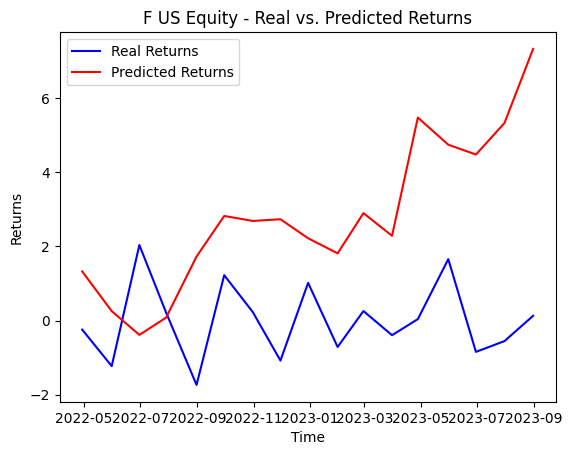

y vs y_pred: (17,) vs (17,)


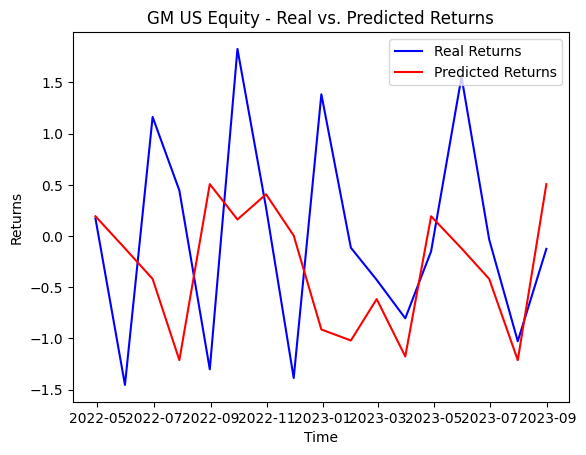

y vs y_pred: (17,) vs (17,)


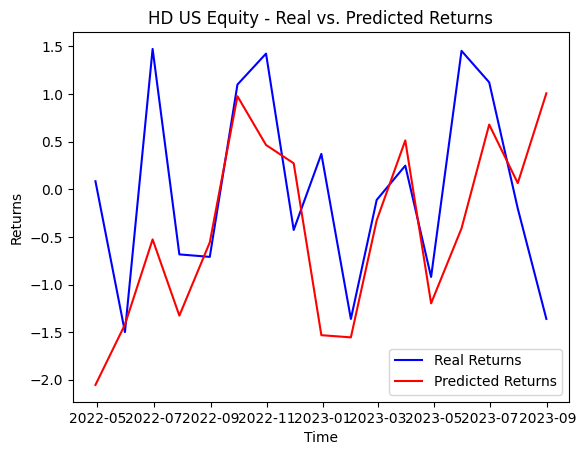

y vs y_pred: (17,) vs (17,)


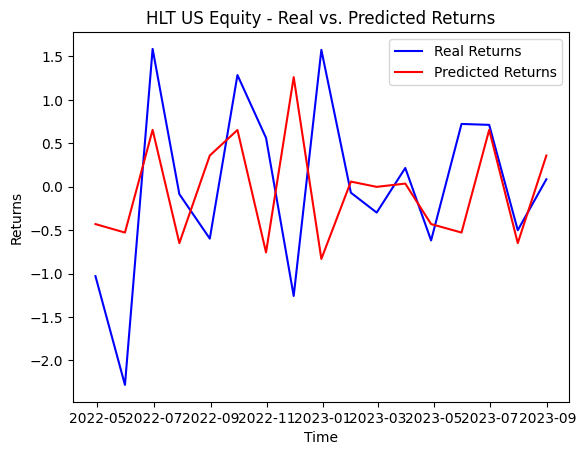

y vs y_pred: (17,) vs (17,)


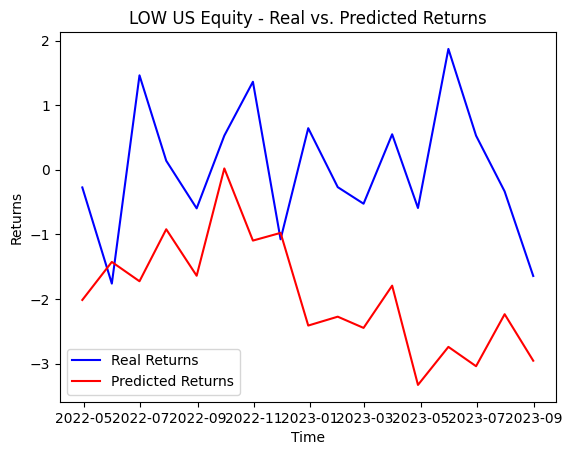

y vs y_pred: (17,) vs (17,)


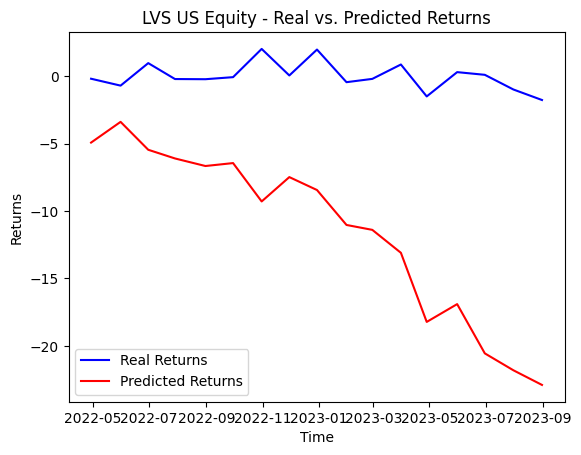

y vs y_pred: (17,) vs (17,)


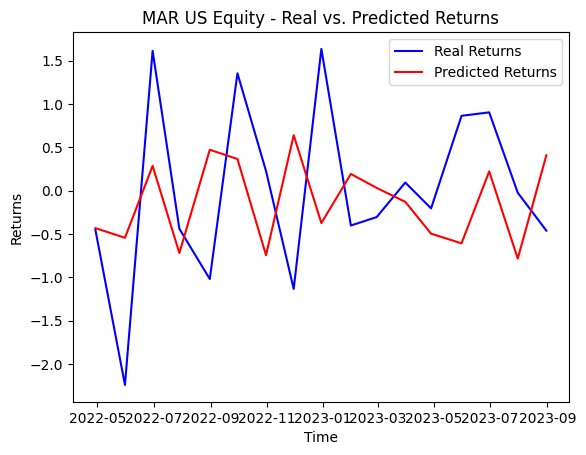

y vs y_pred: (17,) vs (17,)


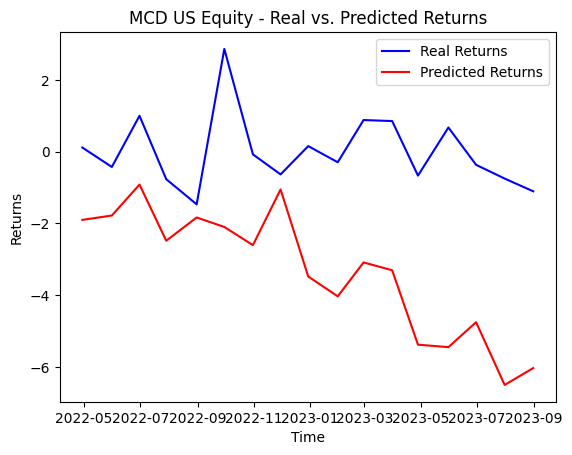

y vs y_pred: (17,) vs (17,)


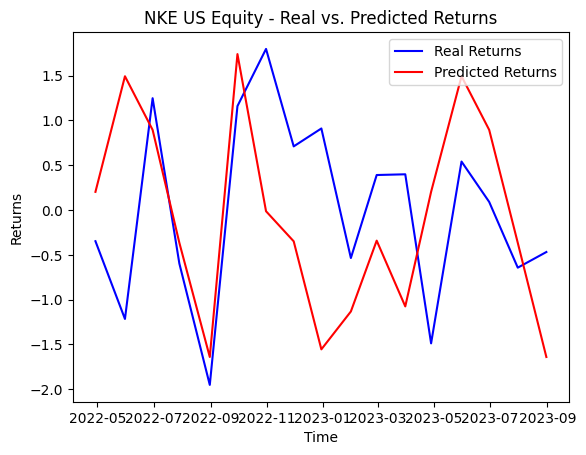

y vs y_pred: (17,) vs (17,)


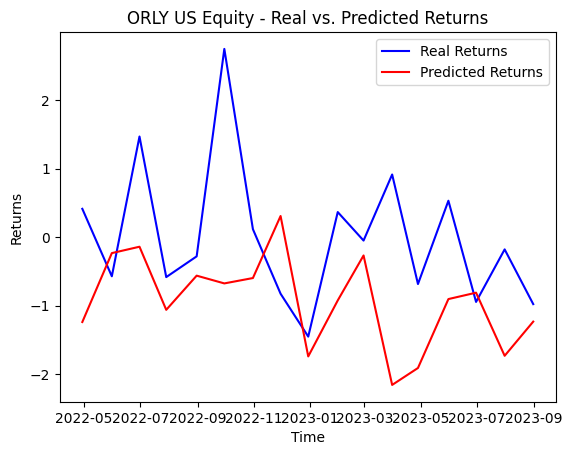

y vs y_pred: (17,) vs (17,)


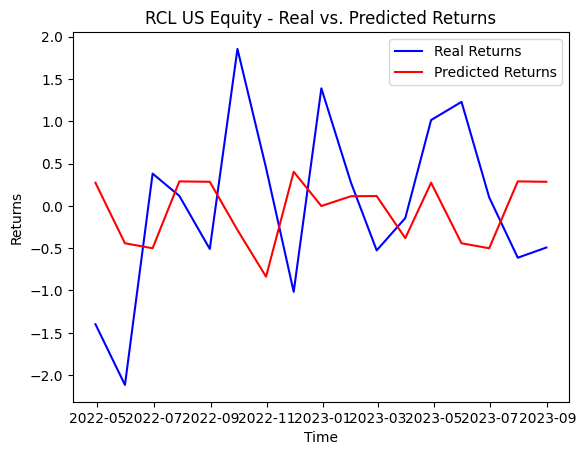

y vs y_pred: (17,) vs (17,)


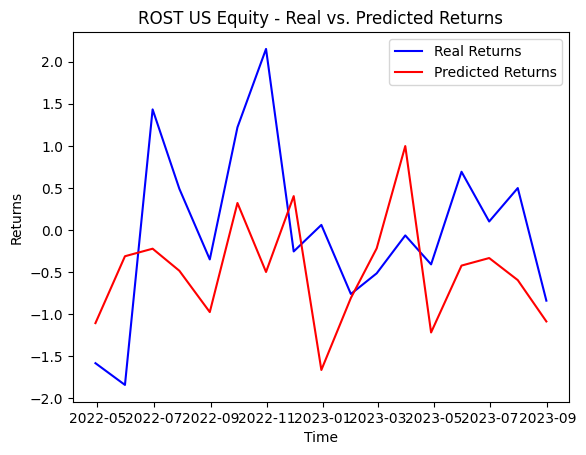

y vs y_pred: (17,) vs (17,)


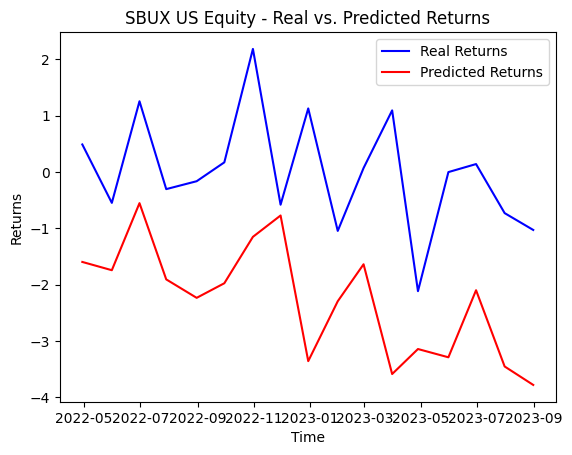

y vs y_pred: (17,) vs (17,)


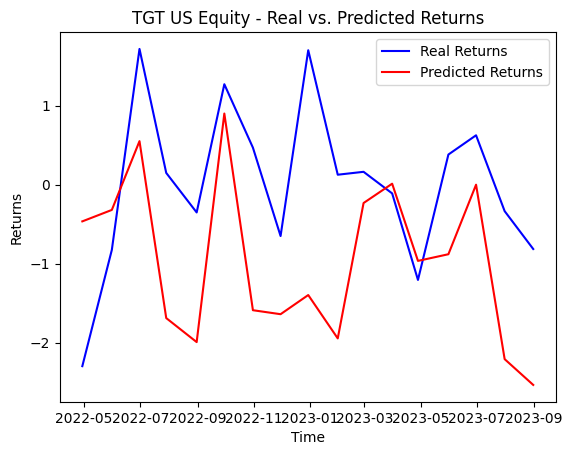

y vs y_pred: (17,) vs (17,)


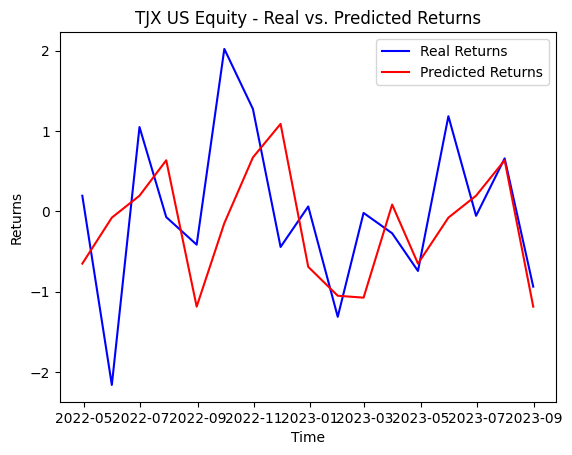

y vs y_pred: (17,) vs (17,)


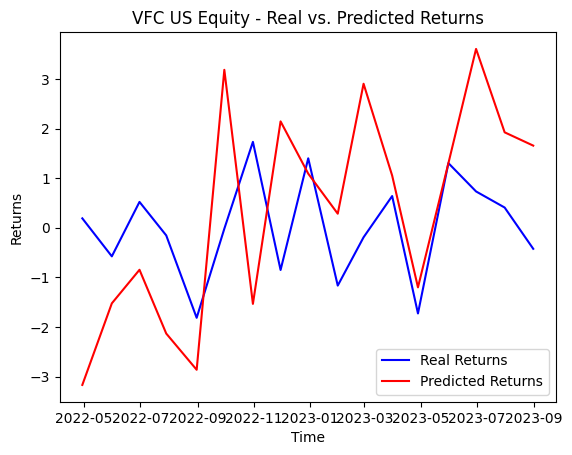

y vs y_pred: (18,) vs (18,)


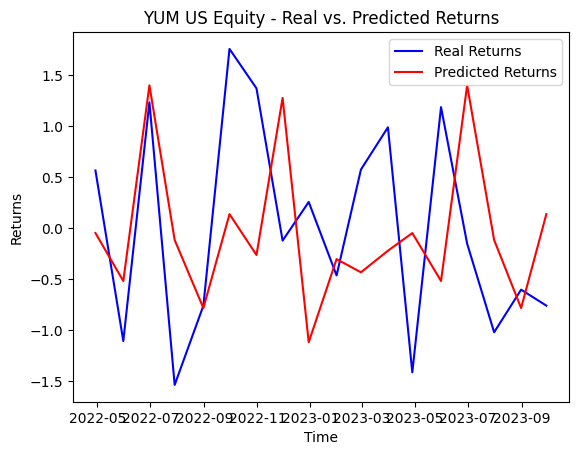

In [ ]:
preds25_next_df = analyze(preds25_next, 'sep', task = 'next',  exo = True)


In [ ]:
preds25_next_df

,AMZN US Equity,APTV US Equity,AZO US Equity,BKNG US Equity,CCL US Equity,CMG US Equity,DG US Equity,EBAY US Equity,F US Equity,GM US Equity,...,MCD US Equity,NKE US Equity,ORLY US Equity,RCL US Equity,ROST US Equity,SBUX US Equity,TGT US Equity,TJX US Equity,VFC US Equity,YUM US Equity
r_squared_adjusted,-3294.153699,-1.433615,-32.875162,-134.650525,-1213.958144,-3.756644,-0.192291,-47.97248,-11.996672,-0.45904,...,-13.156278,-0.628843,-1.145232,-0.343094,-0.323876,-5.461747,-1.288098,-0.054667,-3.471091,-0.292646
rmse,57.403429,1.560005,5.820237,11.646911,34.85625,2.180973,1.091921,6.998034,3.60509,1.207907,...,3.762483,1.276261,1.464661,1.158919,1.150598,2.541997,1.512646,1.02697,2.114495,1.136946
mse,3295.153699,2.433615,33.875162,135.650525,1214.958144,4.756644,1.192291,48.97248,12.996672,1.45904,...,14.156278,1.628843,2.145232,1.343094,1.323876,6.461747,2.288098,1.054667,4.471091,1.292646
y_preds,2022-04-29 -9.138774 2022-05-31 -12.128...,2022-04-29 -0.466304 2022-05-31 -0.462277 ...,2022-04-29 -2.764937 2022-05-31 -1.95898...,2022-04-29 -5.190360 2022-05-31 -2.65781...,2022-04-29 3.117336 2022-05-31 3.92352...,2022-04-29 -2.172959 2022-05-31 -0.230258 ...,2022-05-31 0.762650 2022-06-30 0.899329 ...,2022-04-29 1.613583 2022-05-31 2.37180...,2022-04-29 1.323137 2022-05-31 0.253262 ...,2022-04-29 0.192848 2022-05-31 -0.120646 ...,...,2022-04-29 -1.901750 2022-05-31 -1.780415 ...,2022-04-29 0.202924 2022-05-31 1.493822 ...,2022-04-29 -1.238310 2022-05-31 -0.233344 ...,2022-04-29 0.273413 2022-05-31 -0.442044 ...,2022-04-29 -1.109856 2022-05-31 -0.314082 ...,2022-04-29 -1.596216 2022-05-31 -1.742879 ...,2022-04-29 -0.464870 2022-05-31 -0.320183 ...,2022-04-29 -0.652012 2022-05-31 -0.079182 ...,2022-04-29 -3.167165 2022-05-31 -1.523318 ...,2022-04-29 -0.047656 2022-05-31 -0.517913 ...
y,date_y 2022-04-29 -3.552053 2022-05-31 -0....,date_y 2022-04-29 -0.039882 2022-05-31 -1....,date_y 2022-04-29 0.628578 2022-05-31 0....,date_y 2022-04-29 -0.098807 2022-05-31 -2....,date_y 2022-04-29 -0.852656 2022-05-31 -1....,date_y 2022-04-29 -0.522749 2022-05-31 -0....,date_y 2022-05-31 1.735380 2022-06-30 0....,date_y 2022-04-29 -0.568148 2022-05-31 -1....,date_y 2022-04-29 -0.244927 2022-05-31 -1....,date_y 2022-04-29 0.171913 2022-05-31 -1....,...,date_y 2022-04-29 0.116014 2022-05-31 -0....,date_y 2022-04-29 -0.348055 2022-05-31 -1....,date_y 2022-04-29 0.412452 2022-05-31 -0....,date_y 2022-04-29 -1.398326 2022-05-31 -2....,date_y 2022-04-29 -1.586550 2022-05-31 -1....,date_y 2022-04-29 0.487445 2022-05-31 -0....,date_y 2022-04-29 -2.295792 2022-05-31 -0....,date_y 2022-04-29 0.193324 2022-05-31 -2....,date_y 2022-04-29 0.189496 2022-05-31 -0....,date_y 2022-04-29 0.565858 2022-05-31 -1....
